### 비구독형 코랩 환경에서 행의 크기가 억단위인 경우, 리소스 문제로 세션이 자동으로 종료되는 문제가 있습니다. 따라서 3천만 개로 행의 수를 조절하여 테스트를 진행한 것을 알려드립니다.

In [ ]:
import timeit

import cudf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(f"{cudf.__version__=}")

cudf.__version__='25.02.01'


In [ ]:
rng = np.random.default_rng(seed=0)

In [ ]:
timeit_number = 30
num_rows = 30000000
sub_sample = int(num_rows / 30)

In [ ]:
pdf = pd.DataFrame(
    {
        "numbers": rng.integers(-1000, 1000, num_rows, dtype="int64"),
        "business": rng.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,165,Buckees
1,328,McD
2,-124,Walmart
3,883,Walmart
4,-518,Walmart
...,...,...
29999995,988,McD
29999996,-63,Walmart
29999997,-932,McD
29999998,601,McD


In [ ]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,165,Buckees
1,328,McD
2,-124,Walmart
3,883,Walmart
4,-518,Walmart
...,...,...
29999995,988,McD
29999996,-63,Walmart
29999997,-932,McD
29999998,601,McD


In [ ]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [ ]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=timeit_number
)

In [ ]:
pdf = pdf.head(sub_sample)
gdf = gdf.head(sub_sample)

In [ ]:
pandas_concat = timeit.timeit(
    lambda: pd.concat([pdf, pdf, pdf]), number=timeit_number
)

In [ ]:
cudf_concat = timeit.timeit(
    lambda: cudf.concat([gdf, gdf, gdf]), number=timeit_number
)

In [ ]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=timeit_number,
)

In [ ]:
pdf = pd.DataFrame(
    {
        "numbers": rng.integers(
            -1000, 1000, int(sub_sample / 10), dtype="int64"
        ),
        "business": rng.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=int(sub_sample / 10)
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [ ]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=10
)

In [ ]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)
performance_df

,cudf speedup vs. pandas
value_counts,51.375807
concat,9.904613
groupby,14.215954
merge,6.801318


In [ ]:
def performance_plot(df, xlabel=None):
    # ylim is 20% above max value
    ylim_max = df["cudf speedup vs. pandas"].max() + (
        df["cudf speedup vs. pandas"].max() / 20
    )
    ax = df.plot.bar(
        color="#7400ff",
        ylim=(1, ylim_max),
        rot=0,
        xlabel=xlabel,
        ylabel="Speedup factor",
    )
    ax.bar_label(ax.containers[0], fmt="%.0f")
    plt.show()

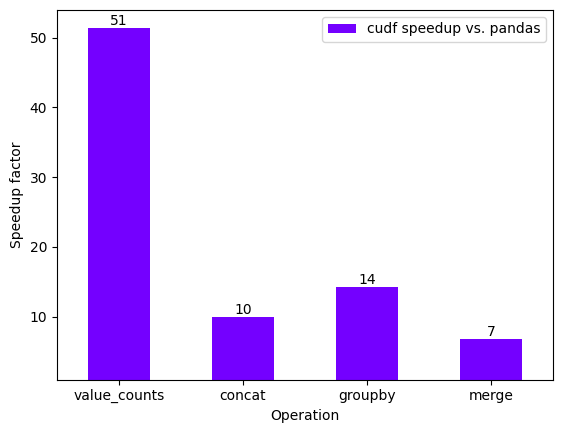

In [ ]:
performance_plot(performance_df, xlabel="Operation")

In [ ]:
import gc

# Cleaning up used memory for later benchmarks
del pdf
del gdf

_ = gc.collect()

NameError: name 'pdf' is not defined

In [ ]:
timeit_number = 20
num_rows = 30_000_000

In [ ]:
pd_series = pd.Series(
    rng.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [ ]:
gd_series = cudf.from_pandas(pd_series)

In [ ]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=timeit_number
)

In [ ]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series,
    gd_series,
    lambda s: s.str.contains(r"[0-9][a-z]"),
    number=timeit_number,
)

In [ ]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=timeit_number
)

In [ ]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)
performance_df

,cudf speedup vs. pandas
upper,247.945943
contains,105.132277
isalpha,760.644159


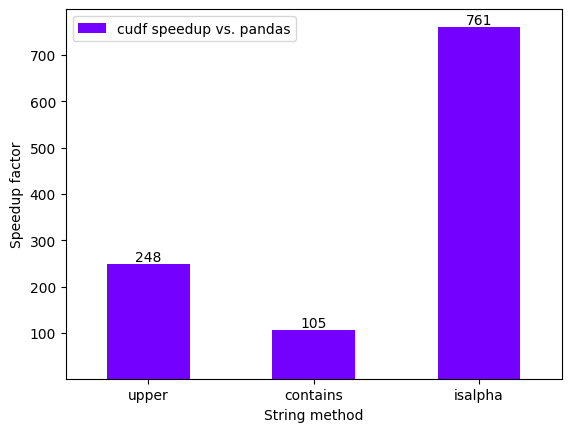

In [ ]:
performance_plot(performance_df, xlabel="String method")

In [ ]:
!nvidia-smi

Mon Apr  7 02:46:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             33W /   70W |     978MiB /  15360MiB |     41%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----